In [2]:
'''
#Gigacow-tools# - preprocessing
This scripts used for single cow data collection work.
Data Tables: gigacow_filter.csv, lactation_filter.csv, traffic_raw_filter.csv
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#access data from local directory
dataDir = Path.cwd().parent.parent/'Data/processed'
gigacow_cols = ['Gigacow_Cow_Id', 'FarmName_Pseudo', 'BreedName', 'BirthDate']
lactation_cols = ['Gigacow_Cow_Id', 'FarmName_Pseudo', 'LactationInfoDate', 'LactationNumber', 'DaysInMilk']
gigacow = pd.read_csv(dataDir/'gigacow_filter.csv', encoding='utf-8', usecols=gigacow_cols)
lactation = pd.read_csv(dataDir/'lactation_filter.csv', encoding='utf-8', usecols=lactation_cols)
traffic = pd.read_csv(dataDir/'traffic_raw_filter.csv', encoding='utf-8', index_col=False)
#check out cows with most milking events
print(traffic.Gigacow_Cow_Id.value_counts().nlargest(10))

5613    11903
6197    11250
4478    11054
3757    10907
2423    10864
3147    10083
4504    10016
5147     9758
3121     9518
5046     9390
Name: Gigacow_Cow_Id, dtype: int64


In [4]:
# Select cows with sufficient data points on single lactation periods
# Try to collect cow's data that contain milking events on lactation periods 1
# fetch all milking traffic events for merging
traffic_milking = traffic.TrafficResult.str.contains('kg', regex=False)
all_list = traffic_milking.index[traffic_milking.values == True].tolist()
milking_total = traffic[traffic.index.isin(all_list)]
milking_total.TrafficEventDateTime = pd.to_datetime(milking_total.TrafficEventDateTime)
milking_total['milking_date'] = milking_total.TrafficEventDateTime.dt.date

# convert data type
milking_total.milking_date = pd.to_datetime(milking_total.milking_date)
lactation.LactationInfoDate = pd.to_datetime(lactation.LactationInfoDate)
# merge all milking events with lactation table for filtering
milking_total = milking_total.merge(lactation, how='left', left_on=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'milking_date'], right_on=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'LactationInfoDate'])

# select records that contains lactation period 1
milking_select1 = milking_total.loc[milking_total['LactationNumber'] == 1]
milking_select1.drop_duplicates(subset=['Gigacow_Cow_Id', 'milking_date', 'LactationNumber', 'DaysInMilk'], inplace=True)
# drop the anomaly data point
milking_select1 = milking_select1.loc[milking_select1.DaysInMilk < 400]
# select sufficient data points on lactation 1
selected1 = milking_select1.Gigacow_Cow_Id.value_counts(ascending=True)
selected1 = selected1.loc[(selected1.values > 280) & (selected1.values < 365)]
cow_list = selected1.index.to_list()
print(len(cow_list), cow_list)

C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_27368\1377343926.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  milking_total.TrafficEventDateTime = pd.to_datetime(milking_total.TrafficEventDateTime)
C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_27368\1377343926.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  milking_total['milking_date'] = milking_total.TrafficEventDateTime.dt.date
C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_27368\1377343926.py:11: SettingWithCopyWarning: 
A value is trying 

16 [5160, 1905, 2039, 6472, 985, 926, 2510, 1738, 74, 1985, 5235, 5088, 5465, 1103, 3718, 2374]


In [5]:
'''
func: Calculate cows age based on birthDate and milkingDate
args: 
    birthDate: cow's birth datetime
    milkingDate: milking events datetime
return: cow age in human years(float)
'''
def countCowAge(birthDate, milkingDate):
    birthDate = pd.to_datetime(birthDate)
    milkingDate = pd.to_datetime(milkingDate)
    days = np.float32(np.datetime64(milkingDate, 'D') - np.datetime64(birthDate, 'D'))
    age = np.around(days/365, 2)
    return age

In [6]:
#select single cow from the traffic table

def data_collector(traffic, gigacow, lactation, cow_id):

    traffic_single_cow = traffic.loc[traffic['Gigacow_Cow_Id'] == cow_id]
    traffic_single_cow.sort_values(by='TrafficEventDateTime', inplace=True)
    traffic_single_cow.index = range(len(traffic_single_cow))

    '''
        Extract Milking Event and its most recent traffic event to calculate T2-T1
        T1: Entry time into the Mjolkfalla
        T2: Entry time into the milking robot
        T2-T1: calculate time difference between T2&T1 (i.e., Time spend in Mjolkfalla/holding area)
    '''
    # locate mikling event by searching 'kg' keyword in traffic result
    # the most recent traffic event to milking event should be pre_milking event
    # need to filter out records with gate failure
    track_milking = traffic_single_cow.TrafficResult.str.contains('kg', regex=False)
    milking_index_list = track_milking.index[track_milking.values == True].tolist()
    pre_milking_index_list = [x-1 for x in milking_index_list]
    milking_traffic = traffic_single_cow[traffic_single_cow.index.isin(milking_index_list)]
    pre_milking_traffic = traffic_single_cow[traffic_single_cow.index.isin(pre_milking_index_list)]

    # drop rows that the gate failed to detect cows but have milking result
    # previous area in milking_traffic table should only be Mjolkfalla
    # previous area in pre_milking_traffic table should not be Mjolkfalla
    failed_list_1_milk = milking_traffic.index[milking_traffic['PreviousArea'] == 'Koridor till Sorteringsgrind 2'].tolist()
    failed_list_1_pre = [x-1 for x in failed_list_1_milk]
    failed_list_2_pre = pre_milking_traffic.index[pre_milking_traffic['PreviousArea'] == 'Mjolkfalla'].tolist()
    failed_list_2_milk = [x+1 for x in failed_list_2_pre]
    # traffic result in pre_milking_traffic table should contain Mjolkfalla
    track_pre_milking = pre_milking_traffic.TrafficResult.str.contains('Mjolkfalla', regex=False)
    failed_list_3_pre = track_pre_milking.index[track_pre_milking.values == False].tolist()
    failed_list_3_milk = [x+1 for x in failed_list_3_pre]

    # remove failed records based on index list
    milking_traffic_failed = failed_list_1_milk + failed_list_2_milk + failed_list_3_milk
    pre_milking_traffic_failed = failed_list_1_pre + failed_list_2_pre + failed_list_3_pre
    milking_traffic.drop(axis=0, index=milking_traffic_failed, inplace=True)
    pre_milking_traffic.drop(axis=0, index=pre_milking_traffic_failed, inplace=True)
    # concatenate two tables to track the traffic directly
    all_milking_traffic = pd.concat([milking_traffic, pre_milking_traffic])
    all_milking_traffic.sort_values(by=['TrafficEventDateTime'], inplace=True)
    #rename table columns for merging
    milking_traffic.rename(columns={"TrafficEventDateTime": "MilkingEventDateTime", "TrafficResult": "MilkProduction", "TimeInArea_totalSeconds": "RoundedSecondsTimeInArea"}, inplace=True)
    pre_milking_traffic.rename(columns={"TrafficEventDateTime": "Pre_MilkingEventDateTime", "TimeInArea_totalSeconds": "RoundedSecondsTimeInArea"}, inplace=True)
    # unify the index of two tables
    milking_traffic.index = range(len(milking_traffic))
    pre_milking_traffic.index = range(len(pre_milking_traffic))
    # inert "pre_traffic_milking" to milking traffic table
    milking_traffic.insert(5, 'Pre_MilkingEventDateTime', pre_milking_traffic['Pre_MilkingEventDateTime'])
    # calculate T2-T1
    milking_traffic.MilkingEventDateTime = pd.to_datetime(milking_traffic.MilkingEventDateTime)
    milking_traffic.Pre_MilkingEventDateTime = pd.to_datetime(milking_traffic.Pre_MilkingEventDateTime)
    milking_traffic['timeDelta_Seconds'] = (milking_traffic['MilkingEventDateTime'] - milking_traffic['Pre_MilkingEventDateTime']).dt.total_seconds()

    #extract traffic result(milk production)
    milking_traffic['MilkProduction'].replace(r"[^0-9.,]+"," ", inplace=True, regex=True)
    milking_traffic['MilkProduction'].replace(r"\s*","", inplace=True, regex=True)
    milking_traffic['MilkProduction'].replace(r"[,]+",".", inplace=True, regex=True)
    milking_traffic['MilkProduction'] = milking_traffic['MilkProduction'].astype('float64')

    # merge all the other features into milking_traffic table
    milking_traffic['MilkingDate'] = milking_traffic.MilkingEventDateTime.dt.date
    milking_traffic.MilkingDate = pd.to_datetime(milking_traffic.MilkingDate)
    lactation.LactationInfoDate = pd.to_datetime(lactation.LactationInfoDate)
    single_cow_merge = milking_traffic.merge(lactation, how='left', left_on=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'MilkingDate'], right_on=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'LactationInfoDate'])
    single_cow_merge = single_cow_merge.merge(gigacow, how='left', left_on=['FarmName_Pseudo', 'Gigacow_Cow_Id'], right_on=['FarmName_Pseudo', 'Gigacow_Cow_Id'])

    # drop failed data points based on RoundedSecondsTimeInArea & timeDelta_Seconds
    single_cow_merge.drop(single_cow_merge.loc[abs(single_cow_merge.timeDelta_Seconds - single_cow_merge.RoundedSecondsTimeInArea) > 300].index, inplace=True)
    single_cow_merge['TrafficDeviceName'].replace(r"[A-Za-z]+\s*","vms", inplace=True, regex=True)
    #calculate age of cows
    single_cow_merge['Age'] = single_cow_merge.apply(lambda x: countCowAge(x['BirthDate'], x['MilkingEventDateTime']), axis=1)
    single_cow_merge.drop(['BirthDate'], axis=1, inplace=True)
    single_cow_merge = single_cow_merge.loc[single_cow_merge.LactationNumber == 1]

    return single_cow_merge

C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_27368\3131045843.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_single_cow.sort_values(by='TrafficEventDateTime', inplace=True)
C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_27368\3131045843.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  milking_traffic.drop(axis=0, index=milking_traffic_failed, inplace=True)
C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_27368\3131045843.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

<Figure size 640x480 with 0 Axes>

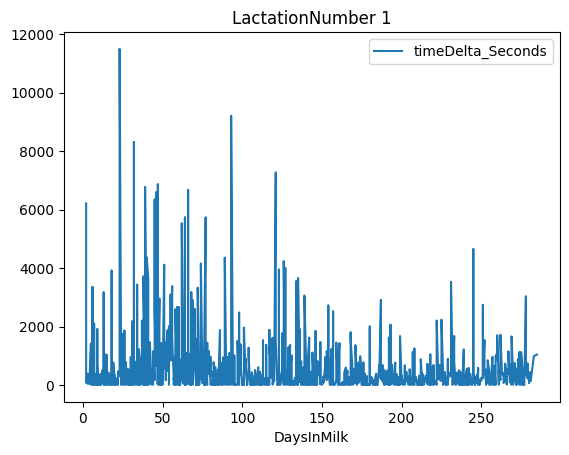

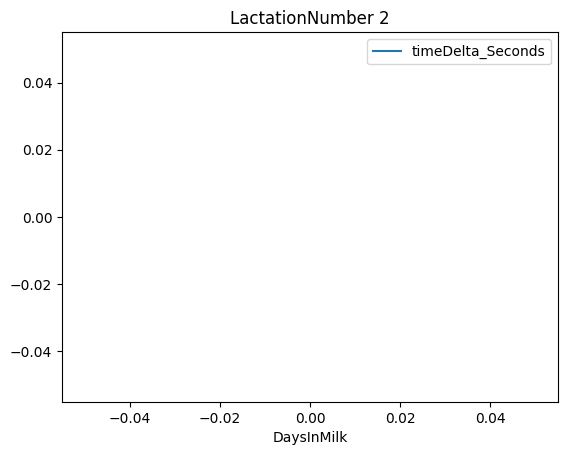

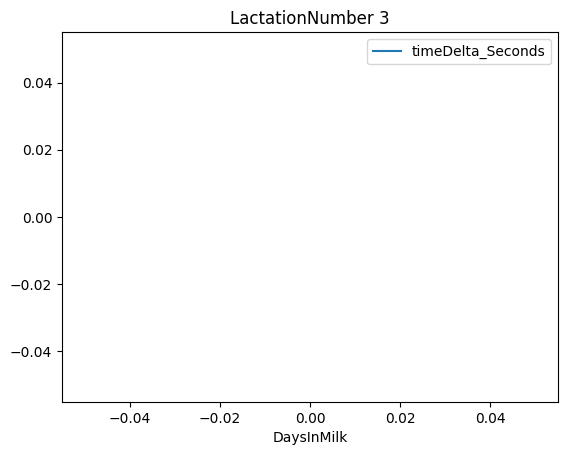

In [7]:
# plot the relations between timeDielta and Lactation/DIM(DaysInMilk)
single_cow_merge = data_collector(traffic, gigacow, lactation, 5160)
plt.figure()
single_cow_merge.loc[single_cow_merge.LactationNumber == 1].plot(x="DaysInMilk", y="timeDelta_Seconds", kind='line', title='LactationNumber 1')
single_cow_merge.loc[single_cow_merge.LactationNumber == 2].plot(x="DaysInMilk", y="timeDelta_Seconds", kind='line', title='LactationNumber 2')
single_cow_merge.loc[single_cow_merge.LactationNumber == 3].plot(x="DaysInMilk", y="timeDelta_Seconds", kind='line', title='LactationNumber 3')
plt.show()


In [8]:
single_cow_merge

,Traffic_Id,FarmName_Pseudo,Gigacow_Cow_Id,GroupName,MilkingEventDateTime,Pre_MilkingEventDateTime,PreviousArea,RoundedSecondsTimeInArea,TrafficDeviceName,MilkProduction,MilkingInterval_totalSeconds,timeDelta_Seconds,MilkingDate,LactationInfoDate,LactationNumber,DaysInMilk,BreedName,Age
1,3437691,a624fb9a,5160,VMS 1,2021-07-05 11:02:14,2021-07-05 09:18:39,Mjolkfalla,6180,vms2,9.07,42900.0,6215.0,2021-07-05,2021-07-05,1.0,2.0,1,1.86
2,4115076,a624fb9a,5160,VMS 1,2021-07-05 20:52:47,2021-07-05 20:51:28,Mjolkfalla,60,vms1,7.67,34980.0,79.0,2021-07-05,2021-07-05,1.0,2.0,1,1.86
3,5672468,a624fb9a,5160,VMS 1,2021-07-06 06:41:09,2021-07-06 06:34:37,Mjolkfalla,360,vms2,7.12,34920.0,392.0,2021-07-06,2021-07-06,1.0,3.0,1,1.86
4,1374327,a624fb9a,5160,VMS 1,2021-07-06 16:25:11,2021-07-06 16:24:28,Mjolkfalla,0,vms2,7.31,34680.0,43.0,2021-07-06,2021-07-06,1.0,3.0,1,1.86
5,8246491,a624fb9a,5160,VMS 1,2021-07-07 01:39:16,2021-07-07 01:35:24,Mjolkfalla,180,vms2,4.30,32880.0,232.0,2021-07-07,2021-07-07,1.0,4.0,1,1.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,5589760,a624fb9a,5160,VMS 1,2022-04-09 22:56:15,2022-04-09 22:50:45,Mjolkfalla,300,vms2,10.09,44880.0,330.0,2022-04-09,2022-04-09,1.0,280.0,1,2.62
846,9254960,a624fb9a,5160,VMS 1,2022-04-10 09:09:40,2022-04-10 09:02:18,Mjolkfalla,420,vms2,8.16,36420.0,442.0,2022-04-10,2022-04-10,1.0,281.0,1,2.62
847,9753641,a624fb9a,5160,VMS 1,2022-04-10 19:50:27,2022-04-10 19:48:09,Mjolkfalla,120,vms2,8.27,38100.0,138.0,2022-04-10,2022-04-10,1.0,281.0,1,2.62
848,770138,a624fb9a,5160,VMS 1,2022-04-12 15:19:48,2022-04-12 15:03:19,Mjolkfalla,960,vms1,13.32,NaN,989.0,2022-04-12,2022-04-12,1.0,283.0,1,2.63


In [9]:
pd.options.mode.chained_assignment = None

mean_totalTimeCost = 0

for i, cow_id in enumerate(cow_list):
    single_cow_merge = data_collector(traffic, gigacow, lactation, cow_id)
    mean_totalTimeCost += single_cow_merge.timeDelta_Seconds.mean()
    print(single_cow_merge.timeDelta_Seconds.mean())
    single_cow_merge["id"] = i+1
    single_cow_merge.dropna(inplace=True)
    fileName = 'ts_targetCows/cow_' + str(i) + '.csv'
    single_cow_merge.to_csv(dataDir/fileName)
print("num of cows: ", len(cow_list))
print("Mean of total time cost: ", mean_totalTimeCost/len(cow_list))

602.0058892815076
701.0011428571429
1254.0363349131121
1248.9582577132487
776.5461624026697
933.9160104986877
620.5258620689655
1245.9826302729527
672.2919418758256
850.4284232365145
980.8686730506156
864.4608294930875
572.4311050477489
602.2002032520326
827.3369330453563
570.3506063947078
num of cows:  16
Mean of total time cost:  832.708812837761
